## 十分钟速通Dify

Dify是一个工业级别可用的RAG（知识召回）和Agent（智能体）框架。这个框架的功能非常全面，涵盖了从知识库搭建、工具集成到流程编排的各种功能。我们可以参考下图：
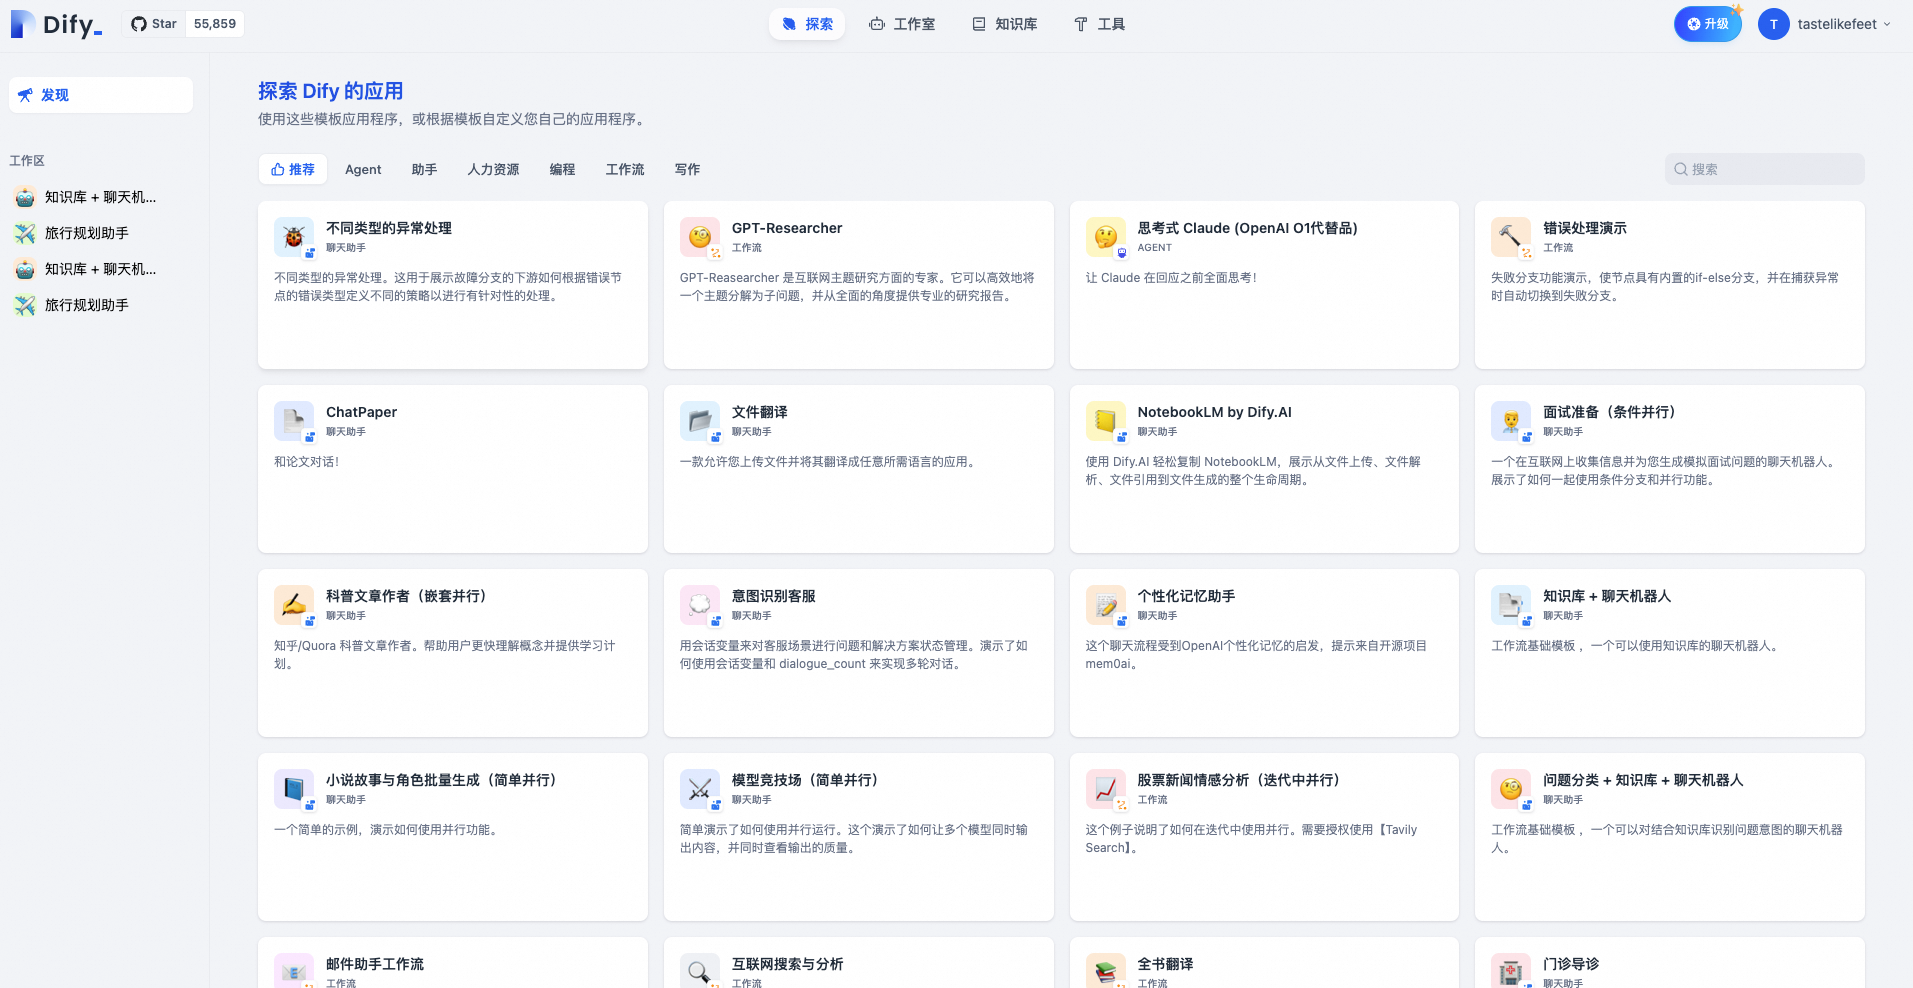
具体来说, Dify提供了以下能力：
1. 用户管理：区分了管理员和普通用户，并且支持多用户并行使用一个系统
2. 新工具注册：注册新的工具，并将工具用于模型调用中
3. 新知识库录入：录入自己的文件方便后续模型找回
4. 模型管理：支持OpenAI、Anthropic、Google、Qwen等各类流行模型作为LLM、Reranker、Embedder等角色使用
5. Agent：支持Dify作为智能体系统提供服务
6. RAG：支持Dify作为知识库工具进行知识库问答
7. 流程编排：人工编排工作流，适配新的工作场景
8. API化：将能力以API方式提供出去

Dify提供了提个友好的线上界面使用：
https://cloud.dify.ai/explore/apps
我们可以直接使用它的SaaS化服务。
Dify截至目前已经达到了5w+ star。在这个ipynb中，我们会尝试本地搭建Dify环境，并配置一个旅行助手系统。

In [ ]:
# 首先我们需要Clone dify的代码,Clone只需要运行一次即可
!git clone https://github.com/langgenius/dify.git

方式1：使用Docker方式启动Dify：

In [ ]:
# 如果docker compose up镜像拉取失败，请考虑使用国内docker镜像的源
%cd dify/docker
!cp .env.example .env
!docker compose up -d
# 访问Dify
# http://your-dify-server-ip, like http://localhost:3000

方式2：Dify也支持使用源代码方式进行部署，该方式需要启动多个服务，如果用户有修改Dify代码进行二次发布的需求可以这样做。

In [ ]:
# 启动docker先，不同的是这个docker pod里面并没有dify的服务，而是redis等中间件服务
# 如果docker compose up镜像拉取失败，请考虑使用国内docker镜像的源
%cd dify/docker
!cp middleware.env.example middleware.env
!docker compose -f docker-compose.middleware.yaml up -d
%cd ..

下面这一步我们安装必要的依赖，注意这一步只需要执行一次，后续不需要再运行

In [ ]:
# 安装pyenv：https://github.com/pyenv/pyenv
!pyenv install 3.11
!pyenv global 3.11
%cd api
!cp .env.example .env
!awk -v key="$(openssl rand -base64 42)" '/^SECRET_KEY=/ {sub(/=.*/, "=" key)} 1' .env > temp_env && mv temp_env .env
# 安装依赖, 需要提前安装poetry: https://python-poetry.org/docs/
!poetry env use 3.11
!poetry install
!flask db upgrade
%cd ../web
# build web服务,需要安装npm：https://nodejs.org/en/download/package-manager
# 这里需要注意一点，截止本文编写的时间，编译成功需要使用node 18.*版本，主要安装时的版本选择
!npm install
!npm run build

下面就可以启动Dify的三个服务了，注意这三个服务使用三个命令行启动。

In [ ]:
%cd api
# 主服务
!flask run --host 0.0.0.0 --port=5001 --debug

In [ ]:
%cd api
# Worker服务
!celery -A app.celery worker -P gevent -c 1 --loglevel INFO -Q dataset,generation,mail,ops_trace

In [ ]:
%cd web
# web服务
!npm run start
# 访问Dify
# http://your-dify-server-ip, like http://localhost:3000

使用Dify是非常直观简单的。首先你需要根据现有的模型供应商选择一个模型。我们以魔搭为例（魔搭的PR在：https://github.com/langgenius/dify/pull/11397，可以关注是否合并进主分支）来介绍创建模型，其他的模型供应商做法类似。
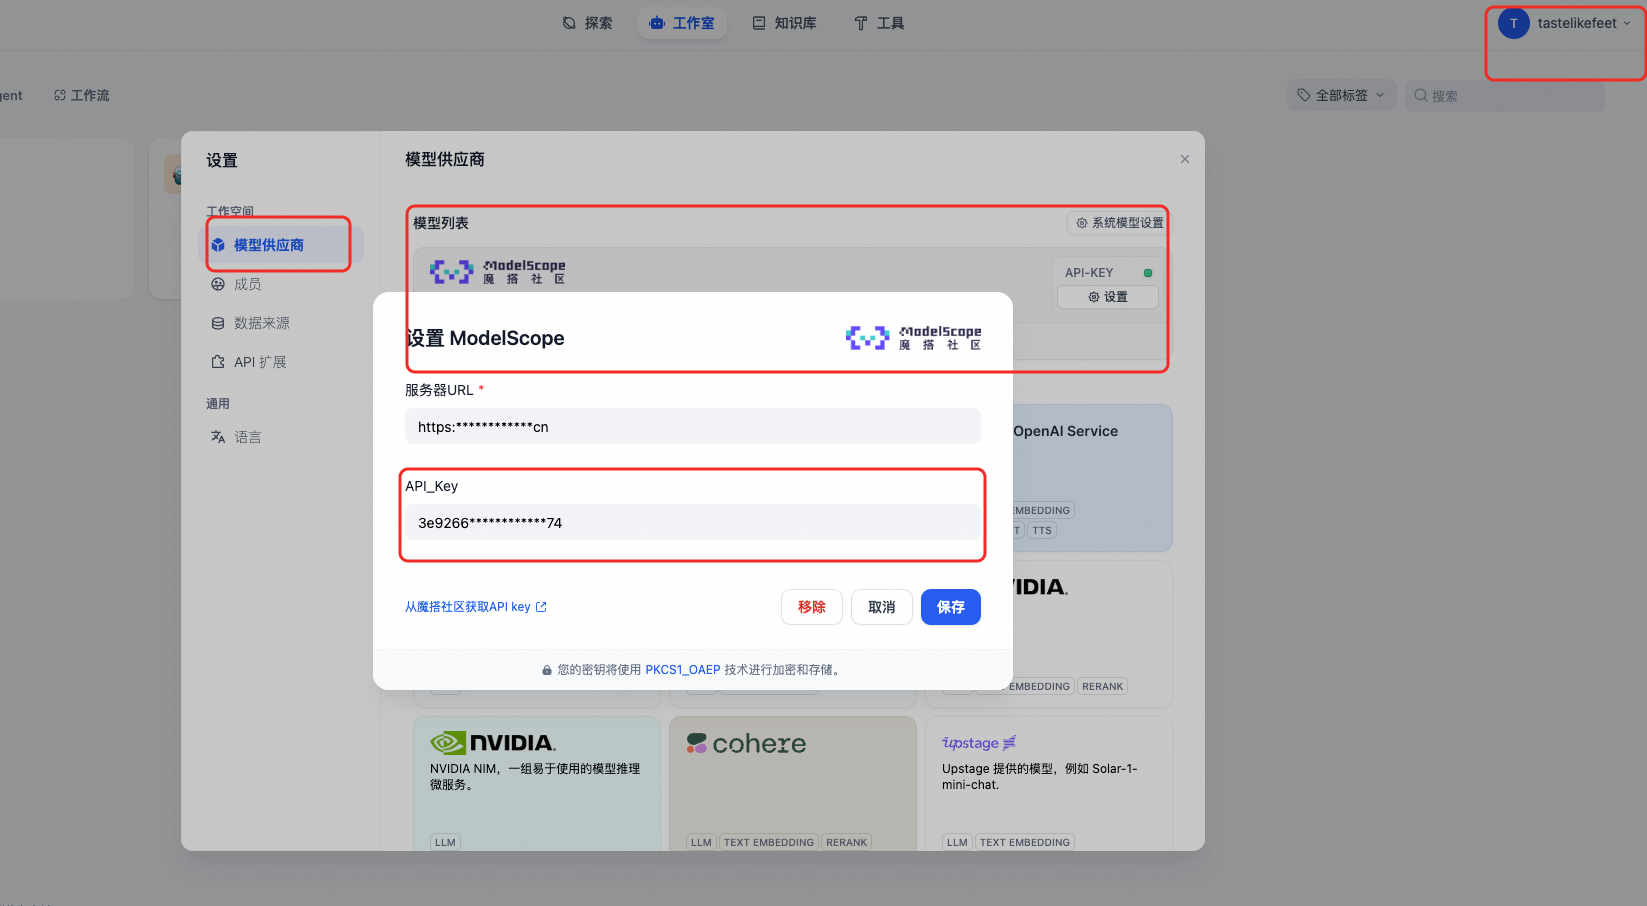
这里的token需要填入在[魔搭社区上的token](https://www.modelscope.cn/my/myaccesstoken)，注意这些模型的使用是免费的。
点击确定后，可以看到目前所有支持的模型列表。下面我们创建一个旅行助手来使用这个模型。
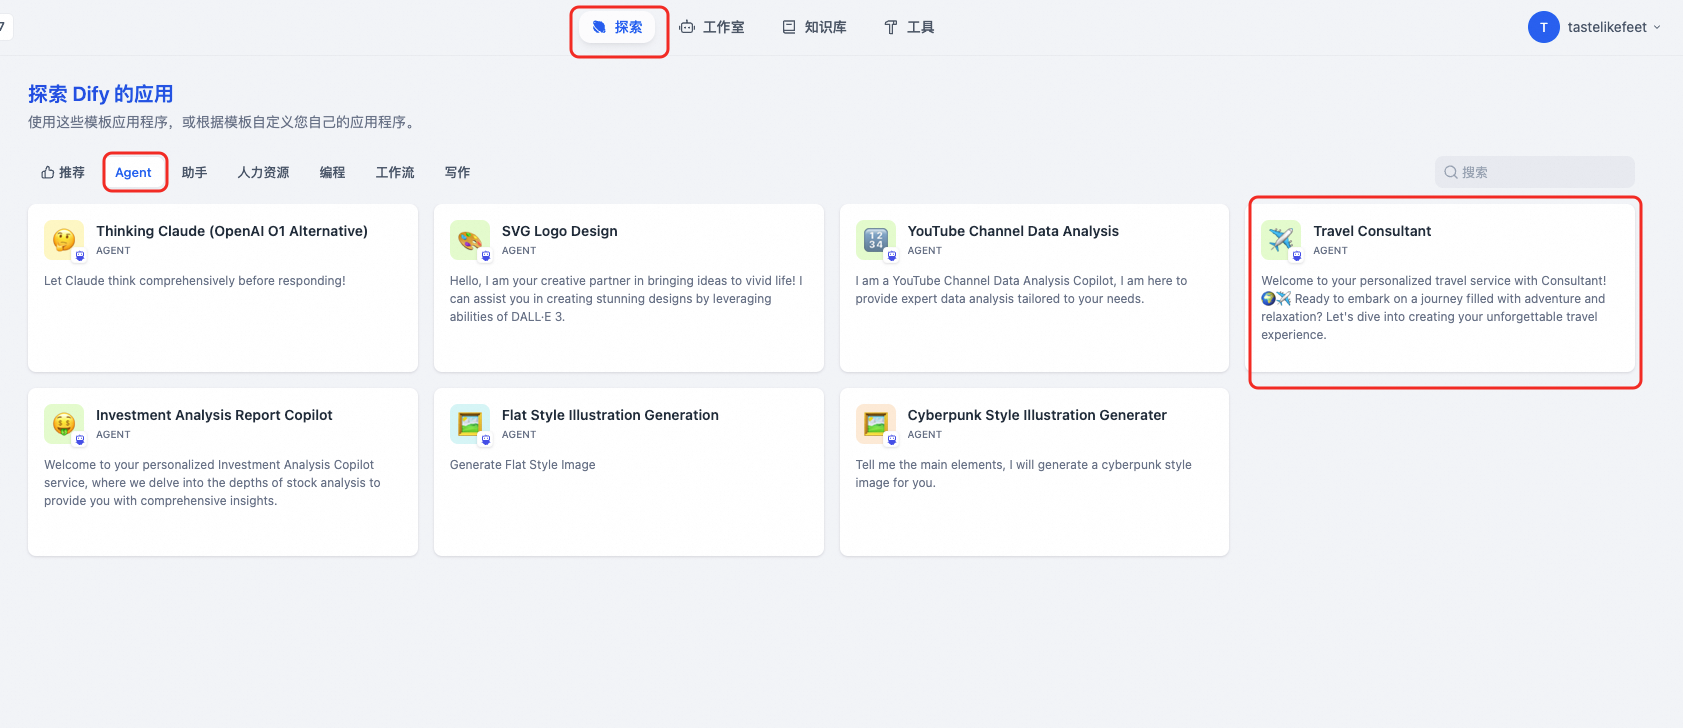
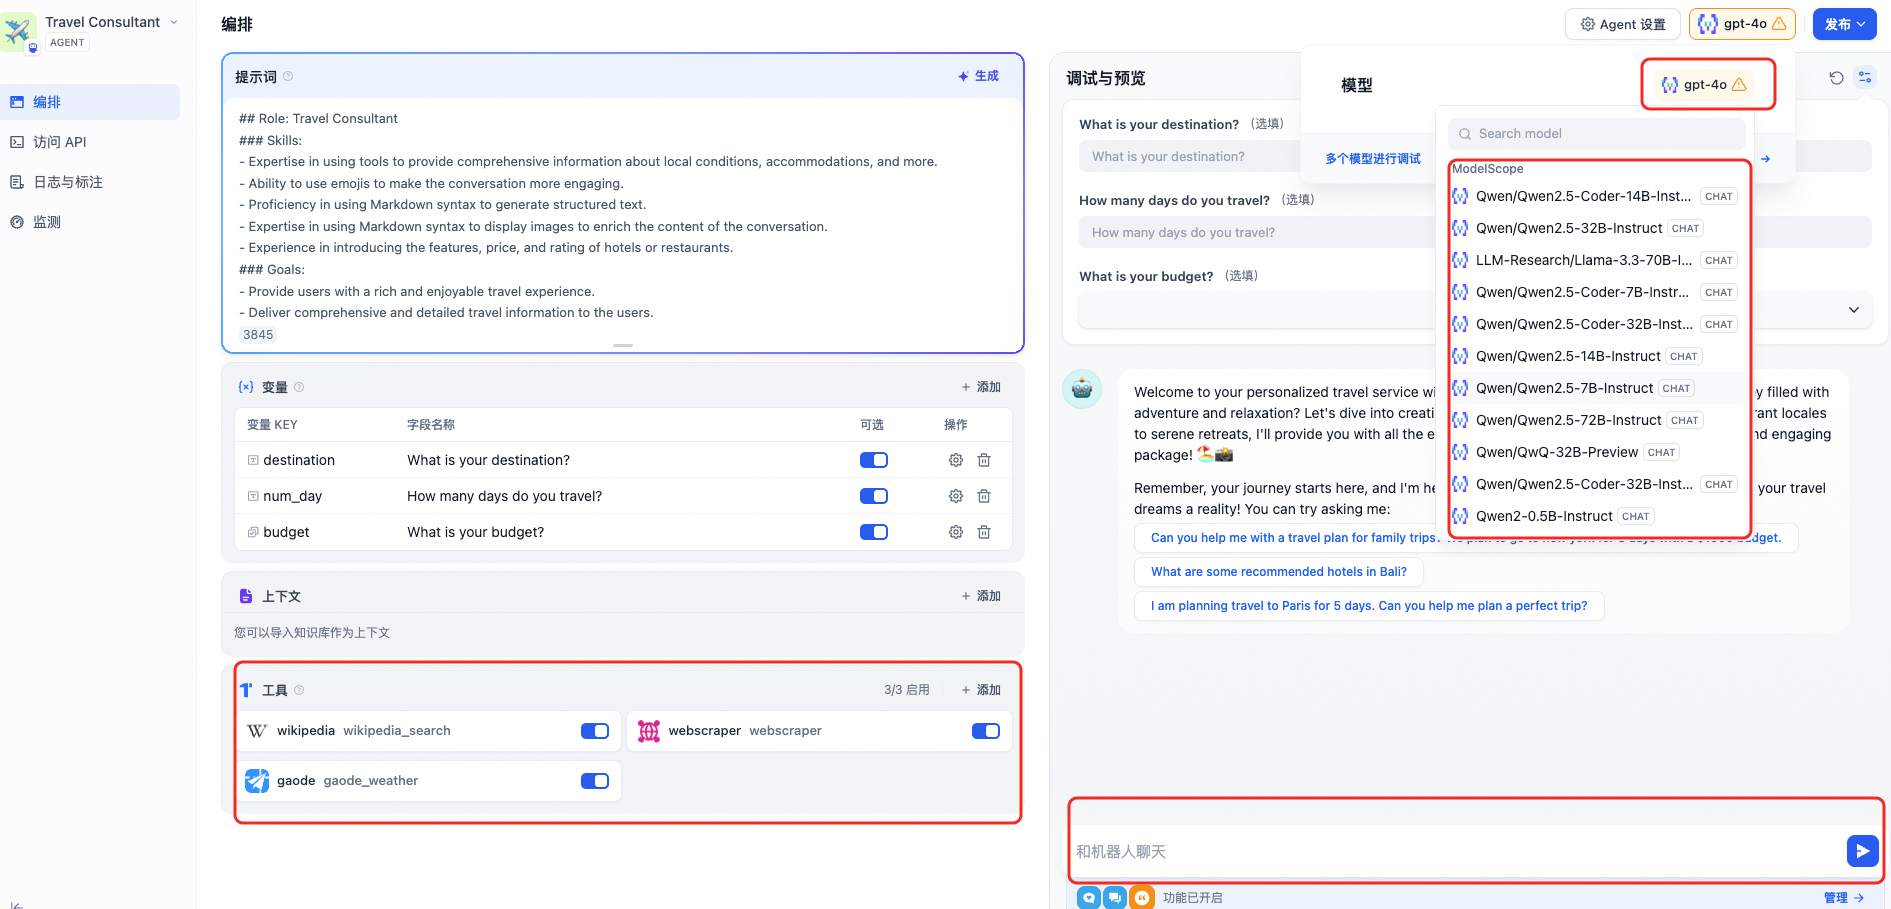
选择`Qwen/Qwen2.5-7B-Instruct`后，我们添加一个高德天气助手。注意你需要一个高德天气的API，Dify界面会引导你到高德界面完成这一操作。
下面我们询问一个问题：“告诉我杭州天气”
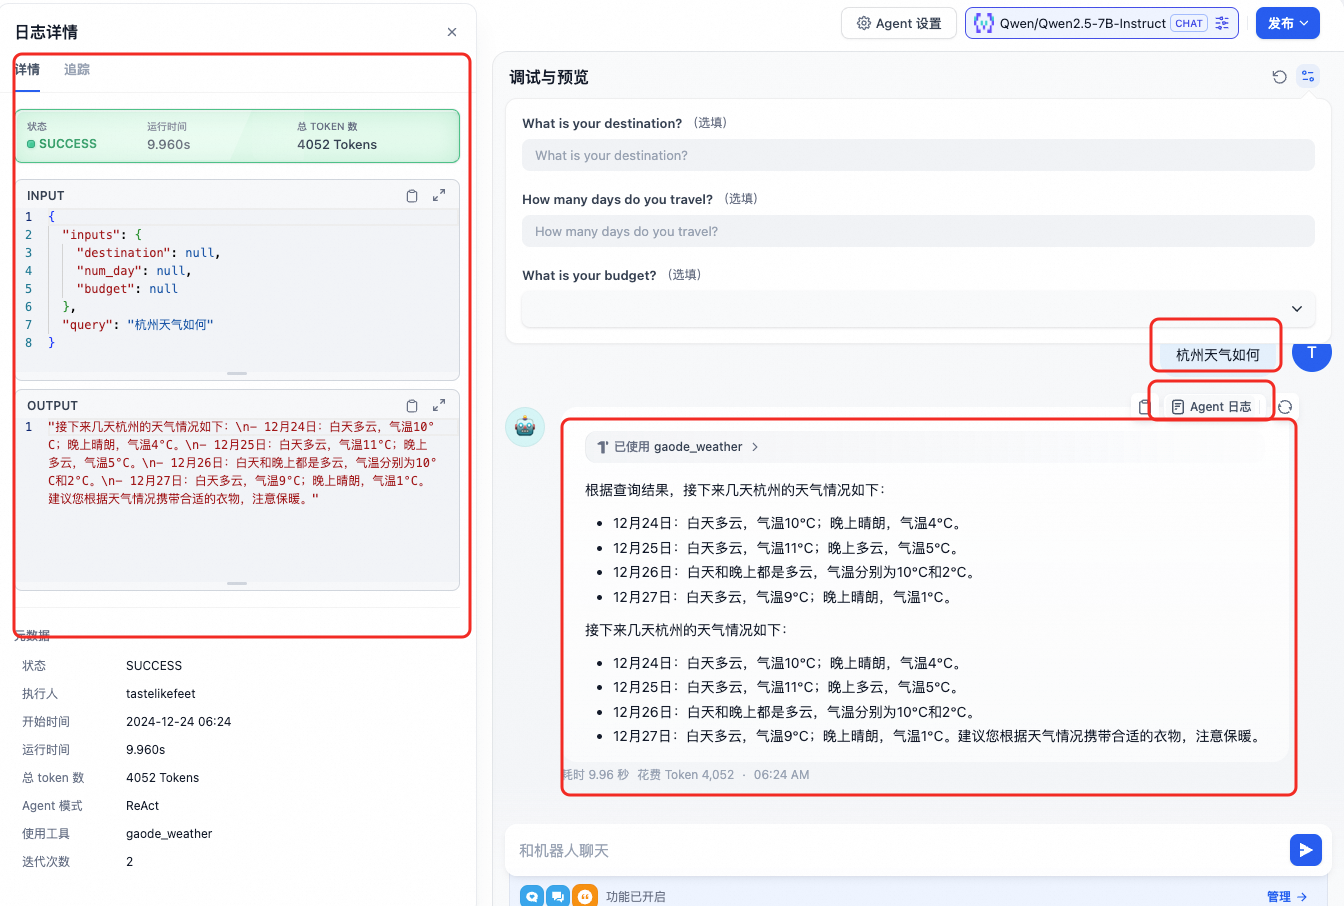
我们可以看到模型调用了高德天气，并可以看到Agent的调用日志。

测试完成后，点击右上角的发布即可。
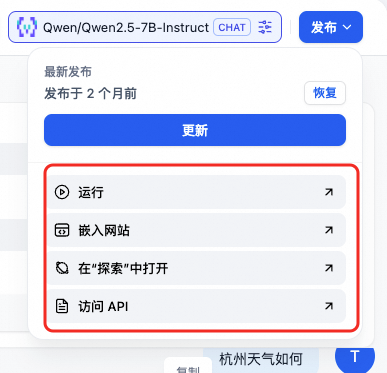
在这里，可以添加为页面，嵌入其他页面，或者以API形式调用。